<a href="https://colab.research.google.com/github/krupaisaaczp/PDF_malware_detection/blob/main/PDF_Malware_Detction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Installations**

In [1]:
%pip install pandas numpy matplotlib seaborn tqdm joblib pymupdf python-magic python-docx

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikeras scikit-learn==1.2.2

  Using cached scikit_learn-1.2.2-cp311-cp311-win_amd64.whl.metadata (11 kB)
Using cached scikit_learn-1.2.2-cp311-cp311-win_amd64.whl (8.3 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.13.0 requires scikit-learn<2,>=1.3.2, but you have scikit-learn 1.2.2 which is incompatible.


In [3]:
!pip install -U scikit-learn imbalanced-learn


  Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl.metadata (15 kB)
Using cached scikit_learn-1.6.1-cp311-cp311-win_amd64.whl (11.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


# **Data Preprocessing & Feature Engineering**

**1. Load & Inspect the Dataset**

In [4]:
import pandas as pd

# Load extracted dataset
df = pd.read_csv(r"D:\Final_Batch_1\file_dataset.csv")

# Display first few rows
print(df.head())

# Check data types and missing values
print(df.info())

# Summary statistics
print(df.describe())


           filename    label  header_length  file_size_kb  \
0  file_dataset.csv  unknown           1024       1760.39   
1     02eounrel.pdf   benign           1024        387.63   
2      02frrltr.pdf   benign           1024        244.92   
3      02govbnd.pdf   benign           1024        241.19   
4        02solp.pdf   benign           1024        358.99   

                  file_type  \
0  application/vnd.ms-excel   
1           application/pdf   
2           application/pdf   
3           application/pdf   
4           application/pdf   

                                        text_preview  num_pages  is_encrypted  \
0  filename,label,header_length,file_size_kb,file...        NaN           NaN   
1                                                NaN       34.0           0.0   
2                                                NaN       29.0           0.0   
3                                                NaN       34.0           0.0   
4                                        

Loads the dataset into a Pandas DataFrame.

Checks data types, missing values, and summary statistics to identify potential issues.


2. Handling Missing Values

In [5]:
# Count missing values in each column
print(df.isnull().sum())

# Fill missing values with appropriate methods
df.fillna(0, inplace=True)  # Replacing NaN with 0

# Verify if missing values are handled
print(df.isnull().sum())

filename                  0
label                     0
header_length             0
file_size_kb              0
file_type                 0
text_preview          17593
num_pages                 1
is_encrypted              1
pdf_version             261
has_javascript            1
has_embedded_files        1
has_openaction            1
has_launch                1
dtype: int64
filename              0
label                 0
header_length         0
file_size_kb          0
file_type             0
text_preview          0
num_pages             0
is_encrypted          0
pdf_version           0
has_javascript        0
has_embedded_files    0
has_openaction        0
has_launch            0
dtype: int64


Machine learning models cannot handle missing values directly.

If the missing values are too many, we can consider dropping the column.

**3. Convert Categorical Labels to Numeric**

In [6]:
from sklearn.preprocessing import LabelEncoder

# Convert 'label' column (benign/malicious) to numbers
encoder = LabelEncoder()
df["label"] = encoder.fit_transform(df["label"])  # benign → 0, malicious → 1

# Verify conversion
print(df["label"].value_counts())  # Check distribution


label
0    9107
1    8486
2       1
Name: count, dtype: int64


**4. Feature Selection & Removing Unnecessary Columns**

In [7]:
# Drop non-relevant columns
df = df.drop(columns=["filename"], errors="ignore")

# Check new dataset structure
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17594 entries, 0 to 17593
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   label               17594 non-null  int32  
 1   header_length       17594 non-null  int64  
 2   file_size_kb        17594 non-null  float64
 3   file_type           17594 non-null  object 
 4   text_preview        17594 non-null  object 
 5   num_pages           17594 non-null  float64
 6   is_encrypted        17594 non-null  float64
 7   pdf_version         17594 non-null  object 
 8   has_javascript      17594 non-null  float64
 9   has_embedded_files  17594 non-null  float64
 10  has_openaction      17594 non-null  float64
 11  has_launch          17594 non-null  float64
dtypes: float64(7), int32(1), int64(1), object(3)
memory usage: 1.5+ MB
None


The "filename" column does not contribute to malware detection.

Only keeps meaningful features.

**5. Feature Scaling**

Identify and drop Non-Numeric Columns

In [8]:
# Check data types
print(df.dtypes)

# Find columns that are not numeric
non_numeric_cols = df.select_dtypes(include=["object"]).columns
print("🛑 Non-numeric columns:", non_numeric_cols)


label                   int32
header_length           int64
file_size_kb          float64
file_type              object
text_preview           object
num_pages             float64
is_encrypted          float64
pdf_version            object
has_javascript        float64
has_embedded_files    float64
has_openaction        float64
has_launch            float64
dtype: object
🛑 Non-numeric columns: Index(['file_type', 'text_preview', 'pdf_version'], dtype='object')


In [9]:
# Drop non-numeric columns
df = df.drop(columns=non_numeric_cols, errors="ignore")


**6. Scaling**

In [10]:
from sklearn.preprocessing import StandardScaler

# Select features and target again
X = df.drop(columns=["label"])  # Features
y = df["label"]  # Target variable

# Apply Standard Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame
X = pd.DataFrame(X_scaled, columns=X.columns)

print("✅ Data successfully preprocessed and scaled!")


✅ Data successfully preprocessed and scaled!


 ***6.Split Data for Training & Testing***

In [11]:
from sklearn.model_selection import train_test_split

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")


Training samples: 14075, Testing samples: 3519


* 80% is used to train the models.
- 20% is used for evaluation.
- This prevents overfitting.

# **Model Training & Evaluation**

Train Multiple Models
- Random Forest
- SVM
- AdaBoost
- Gradient Descent
- DNN


1. Random Forest Implementation

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

# Initialize Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluate performance
print("\n📌 Random Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_rf):.4f}")
print(classification_report(y_test, y_pred_rf))

# Save the model
import joblib
joblib.dump(rf_model, "random_forest_model.pkl")
print("✅ Random Forest Model Saved!")


📌 Random Forest Performance:
Accuracy: 0.9039
AUC-ROC: 0.9580
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      1806
           1       0.91      0.90      0.90      1713

    accuracy                           0.90      3519
   macro avg       0.90      0.90      0.90      3519
weighted avg       0.90      0.90      0.90      3519

✅ Random Forest Model Saved!


**2. Support Vector Machine (SVM) Implementation**

In [13]:
from sklearn.svm import SVC

# Initialize SVM with RBF kernel
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Predictions
y_pred_svm = svm_model.predict(X_test)
y_proba_svm = svm_model.predict_proba(X_test)[:, 1]

# Evaluate performance
print("\n📌 SVM Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_svm):.4f}")
print(classification_report(y_test, y_pred_svm))

# Save the model
joblib.dump(svm_model, "svm_model.pkl")
print("✅ SVM Model Saved!")



📌 SVM Performance:
Accuracy: 0.8485
AUC-ROC: 0.9138
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1806
           1       0.84      0.84      0.84      1713

    accuracy                           0.85      3519
   macro avg       0.85      0.85      0.85      3519
weighted avg       0.85      0.85      0.85      3519

✅ SVM Model Saved!


**3. AdaBoost Implementation**

In [14]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize AdaBoost
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)

# Train the model
ada_model.fit(X_train, y_train)

# Predictions
y_pred_ada = ada_model.predict(X_test)
y_proba_ada = ada_model.predict_proba(X_test)[:, 1]

# Evaluate performance
print("\n📌 AdaBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ada):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_ada):.4f}")
print(classification_report(y_test, y_pred_ada))

# Save the model
joblib.dump(ada_model, "adaboost_model.pkl")
print("✅ AdaBoost Model Saved!")



📌 AdaBoost Performance:
Accuracy: 0.8724
AUC-ROC: 0.9360
              precision    recall  f1-score   support

           0       0.89      0.86      0.87      1806
           1       0.86      0.88      0.87      1713

    accuracy                           0.87      3519
   macro avg       0.87      0.87      0.87      3519
weighted avg       0.87      0.87      0.87      3519

✅ AdaBoost Model Saved!


**4. Gradient Boosting Implementation**

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Train the model
gb_model.fit(X_train, y_train)

# Predictions
y_pred_gb = gb_model.predict(X_test)
y_proba_gb = gb_model.predict_proba(X_test)[:, 1]

# Evaluate performance
print("\n📌 Gradient Boosting Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_gb):.4f}")
print(classification_report(y_test, y_pred_gb))

# Save the model
joblib.dump(gb_model, "gradient_boosting_model.pkl")
print("✅ Gradient Boosting Model Saved!")



📌 Gradient Boosting Performance:
Accuracy: 0.9173
AUC-ROC: 0.9686
              precision    recall  f1-score   support

           0       0.89      0.96      0.92      1806
           1       0.96      0.87      0.91      1713

    accuracy                           0.92      3519
   macro avg       0.92      0.92      0.92      3519
weighted avg       0.92      0.92      0.92      3519

✅ Gradient Boosting Model Saved!


**5. Deep Neural Network (DNN)**

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

dnn_model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation="relu"),
    Dropout(0.3),
    Dense(1, activation="sigmoid")
])

dnn_model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

history = dnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=32, verbose=1)

y_proba_dnn = dnn_model.predict(X_test).flatten()
auc_dnn = roc_auc_score(y_test, y_proba_dnn)

print(f"\n🏆 Deep Learning Model AUC: {auc_dnn:.4f}")

dnn_model.save("dnn_pdf_malware_model.h5")
print("✅ Deep Neural Network Model Saved!")


c:\Users\krupa\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7615 - loss: 0.5463 - val_accuracy: 0.8471 - val_loss: 0.3744
Epoch 2/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8615 - loss: 0.3697 - val_accuracy: 0.8477 - val_loss: 0.3479
Epoch 3/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8661 - loss: 0.3579 - val_accuracy: 0.8554 - val_loss: 0.3351
Epoch 4/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8771 - loss: 0.3215 - val_accuracy: 0.8679 - val_loss: 0.3199
Epoch 5/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8772 - loss: 0.3245 - val_accuracy: 0.8747 - val_loss: 0.3104
Epoch 6/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8888 - loss: 0.3003 - val_accuracy: 0.8809 - val_loss: 0.3000
Epoch 7/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8892 - loss: 0.3028 - val_accuracy: 0.8866 - val_loss: 0.2954
Epoch 8/30
440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9011 - loss: 0.2828 - val_accuracy: 0.


🏆 Deep Learning Model AUC: 0.9484
✅ Deep Neural Network Model Saved!


**6. Compare All Models & Select the Best**

In [17]:
models = {
    "Random Forest": (rf_model, y_proba_rf),
    "SVM": (svm_model, y_proba_svm),
    "AdaBoost": (ada_model, y_proba_ada),
    "Gradient Boosting": (gb_model, y_proba_gb)
}

# Find the best model based on AUC-ROC
best_model = max(models.items(), key=lambda x: roc_auc_score(y_test, x[1][1]))
print(f"\n🏆 Best Model: {best_model[0]} with AUC: {roc_auc_score(y_test, best_model[1][1]):.4f}")



🏆 Best Model: Gradient Boosting with AUC: 0.9686


# **Hyperparameter Optimization**

**Installations**

In [18]:
import numpy as np
import pandas as pd
import joblib
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

2. Load & Check Class Distribution

In [19]:
# Load dataset
df = pd.read_csv(r"D:\Final_Batch_1\file_dataset.csv")

# Drop non-feature columns
X = df.drop(columns=["label", "filename"], errors="ignore")
y = df["label"]

# Check class distribution
unique, counts = np.unique(y, return_counts=True)
print("Class Distribution Before Removing Rare Classes:", dict(zip(unique, counts)))

# ✅ Remove classes that have only 1 sample
df = df.groupby("label").filter(lambda x: len(x) > 1)

# Update X and y after filtering
X = df.drop(columns=["label", "filename"], errors="ignore")
y = df["label"]

# Check class distribution after filtering
unique, counts = np.unique(y, return_counts=True)
print("Class Distribution After Removing Rare Classes:", dict(zip(unique, counts)))

# ✅ Use stratified splitting only if all classes have at least 2 samples
if min(counts) >= 2:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
else:
    print("🚨 Warning: Some classes still have fewer than 2 samples. Using stratify=None.")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=None, random_state=42)

print("✅ Train-Test Split Completed Successfully!")

Class Distribution Before Removing Rare Classes: {'benign': 9107, 'malicious': 8486, 'unknown': 1}
Class Distribution After Removing Rare Classes: {'benign': 9107, 'malicious': 8486}
✅ Train-Test Split Completed Successfully!


3.  Apply SMOTE to Balance Data

In [20]:
X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# Apply SMOTE
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check new class distribution
unique_balanced, counts_balanced = np.unique(y_train_balanced, return_counts=True)
print("Class Distribution After SMOTE:", dict(zip(unique_balanced, counts_balanced)))

Class Distribution After SMOTE: {'benign': 7285, 'malicious': 7285}


4. Define Stratified K-Fold for Cross-Validation

In [21]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# **Hyperparameter Tuning for SVM**

---



In [22]:
from sklearn.experimental import enable_halving_search_cv  # Enable HalvingGridSearchCV
from sklearn.model_selection import RandomizedSearchCV, HalvingGridSearchCV
from sklearn.svm import SVC

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.01, 0.0001],
    'kernel': ['rbf']
}

# Use RandomizedSearchCV (Faster)
random_search = RandomizedSearchCV(
    SVC(probability=True, random_state=42),
    param_distributions=param_grid,
    n_iter=5,  # Lower n_iter to reduce time
    cv=3,      # Reduce folds
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)
print(f"Best Parameters (RandomizedSearchCV): {random_search.best_params_}")

# Use HalvingGridSearchCV (Successive Halving)
halving_search = HalvingGridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid,
    factor=2,  # Eliminates half of configurations at each iteration
    min_resources="exhaust",
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

halving_search.fit(X_train, y_train)
print(f"Best Parameters (HalvingGridSearchCV): {halving_search.best_params_}")


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Parameters (RandomizedSearchCV): {'kernel': 'rbf', 'gamma': 0.01, 'C': 10}
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 1759
max_resources_: 14074
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 9
n_resources: 1759
Fitting 3 folds for each of 9 candidates, totalling 27 fits
----------
iter: 1
n_candidates: 5
n_resources: 3518
Fitting 3 folds for each of 5 candidates, totalling 15 fits
----------
iter: 2
n_candidates: 3
n_resources: 7036
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 14072
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters (HalvingGridSearchCV): {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


**Training with best hyperparameters**

In [23]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import joblib

# Extract the best parameters from the search
best_params = random_search.best_params_  # Change to halving_search.best_params_ if needed

# Train the final SVM model with optimized hyperparameters
final_svm = SVC(
    C=best_params["C"],
    gamma=best_params["gamma"],
    kernel=best_params["kernel"],
    probability=True,
    random_state=42
)

final_svm.fit(X_train, y_train)  # Train the model

# Save the trained model
joblib.dump(final_svm, "svm_model.pkl")
print("✅ SVM Model Saved!")


✅ SVM Model Saved!


**Evaluation**


In [24]:
# Make predictions on the test set
y_pred_svm = final_svm.predict(X_test)
y_proba_svm = final_svm.predict_proba(X_test)[:, 1]

# Print evaluation metrics
print("\n📌 SVM Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_svm):.4f}")
print(classification_report(y_test, y_pred_svm))


📌 SVM Performance:
Accuracy: 0.9048
AUC-ROC: 0.9555
              precision    recall  f1-score   support

      benign       0.87      0.95      0.91      1822
   malicious       0.94      0.85      0.90      1697

    accuracy                           0.90      3519
   macro avg       0.91      0.90      0.90      3519
weighted avg       0.91      0.90      0.90      3519



# ***Training with Optuna***

Installations


In [25]:
pip install optuna imbalanced-learn



  Using cached optuna-4.2.1-py3-none-any.whl.metadata (17 kB)
  Using cached alembic-1.14.1-py3-none-any.whl.metadata (7.4 kB)
  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
  Using cached Mako-1.3.9-py3-none-any.whl.metadata (2.9 kB)
Using cached optuna-4.2.1-py3-none-any.whl (383 kB)
Using cached alembic-1.14.1-py3-none-any.whl (233 kB)
Using cached colorlog-6.9.0-py3-none-any.whl (11 kB)
Using cached Mako-1.3.9-py3-none-any.whl (78 kB)


In [26]:
!pip install optuna

In [27]:
# Convert categorical labels to numeric (benign = 0, malicious = 1)
y_train = y_train.map({'benign': 0, 'malicious': 1})
y_test = y_test.map({'benign': 0, 'malicious': 1})



# **Random Forest**
---



In [28]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, average_precision_score

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameter search space
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 5, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)

    # Define the model with trial parameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        class_weight="balanced",  # Handle class imbalance
        random_state=42,
        n_jobs=-1
    )

    # Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Optimize for PR-AUC using average_precision_score
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=make_scorer(average_precision_score))
    return scores.mean()  # Return the average PR-AUC score

# Run Optuna optimization
study = optuna.create_study(direction="maximize")  # We maximize PR-AUC
study.optimize(objective, n_trials=30)  # Run 30 trials

# Best hyperparameters found
print("Best hyperparameters:", study.best_params)


[I 2025-02-25 00:34:01,517] A new study created in memory with name: no-name-e351b769-a8d6-43be-aca4-b03c989aafbe
[I 2025-02-25 00:34:04,878] Trial 0 finished with value: 0.8936646135785488 and parameters: {'n_estimators': 132, 'max_depth': 45, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8936646135785488.
[I 2025-02-25 00:34:08,790] Trial 1 finished with value: 0.8940138827860812 and parameters: {'n_estimators': 392, 'max_depth': 19, 'min_samples_split': 6, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8940138827860812.
[I 2025-02-25 00:34:10,320] Trial 2 finished with value: 0.8763180028851918 and parameters: {'n_estimators': 74, 'max_depth': 39, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.8940138827860812.
[I 2025-02-25 00:34:12,535] Trial 3 finished with value: 0.8941635828031453 and parameters: {'n_estimators': 191, 'max_depth': 17, 'min_samples_split': 10, 'min_samples_leaf': 3}. Best is trial 3 with valu

Best hyperparameters: {'n_estimators': 359, 'max_depth': 11, 'min_samples_split': 8, 'min_samples_leaf': 1}


In [29]:
# Extract the best parameters from Optuna
best_params = study.best_params

# Train the final Random Forest model with the best parameters
final_rf = RandomForestClassifier(
    **best_params, class_weight="balanced", random_state=42, n_jobs=-1
)
final_rf.fit(X_train, y_train)  # Train the model


RandomForestClassifier(class_weight='balanced', max_depth=11,
                       min_samples_split=8, n_estimators=359, n_jobs=-1,
                       random_state=42)

In [30]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred = final_rf.predict(X_test)

# Print evaluation metrics
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1822
           1       0.96      0.89      0.92      1697

    accuracy                           0.93      3519
   macro avg       0.93      0.93      0.93      3519
weighted avg       0.93      0.93      0.93      3519



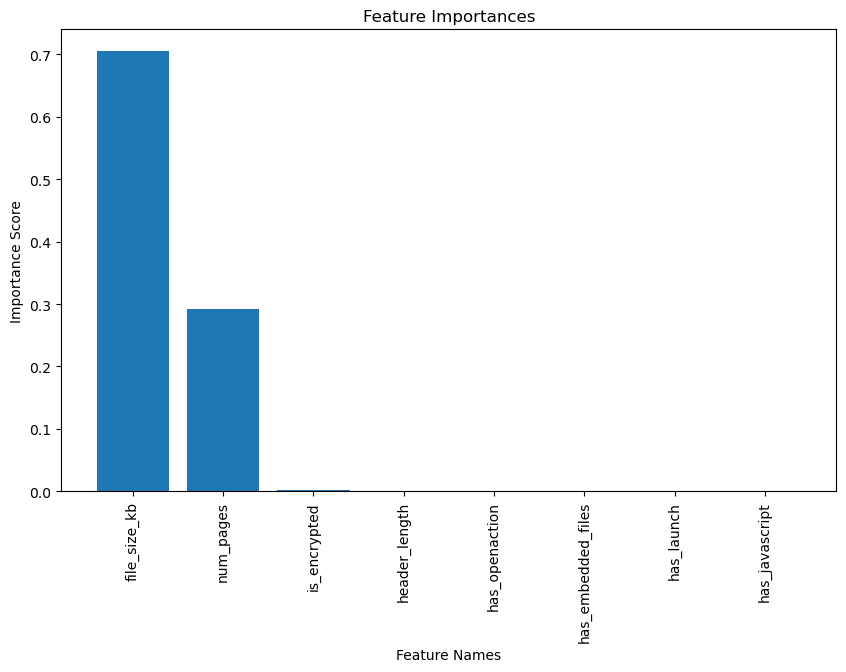

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
feature_importances = final_rf.feature_importances_
feature_names = X_train.columns

# Sort feature importances
indices = np.argsort(feature_importances)[::-1]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlabel("Feature Names")
plt.ylabel("Importance Score")
plt.show()


In [32]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[1751   71]
 [ 185 1512]]


In [33]:
import joblib
joblib.dump(final_rf, "random_forest_model.pkl")  # Save the model


['random_forest_model.pkl']

# **Hyperparameter Tuning for AdaBoost**

---



In [34]:
import optuna
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, average_precision_score

# Define the Optuna optimization function
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)  # Number of weak classifiers
    learning_rate = trial.suggest_float("learning_rate", 0.01, 1.0, log=True)  # Step size
    max_depth = trial.suggest_int("max_depth", 1, 10)  # Depth of base Decision Tree

    # Define AdaBoost with Decision Tree as base estimator
    model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=max_depth),  # Base learner
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reduced CV folds for speed
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=make_scorer(average_precision_score))

    return scores.mean()  # Return PR-AUC score

# Run Optuna optimization (10 trials for speed)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, n_jobs=-1)  # Run in parallel

# Best hyperparameters found
print("Best hyperparameters:", study.best_params)


[I 2025-02-25 00:37:27,433] A new study created in memory with name: no-name-78e25739-7833-44db-8b6d-a85e4ff0c4f6
[I 2025-02-25 00:37:38,289] Trial 6 finished with value: 0.8874454960142124 and parameters: {'n_estimators': 65, 'learning_rate': 0.8185437575470851, 'max_depth': 4}. Best is trial 6 with value: 0.8874454960142124.
[I 2025-02-25 00:37:52,584] Trial 0 finished with value: 0.8721458788186114 and parameters: {'n_estimators': 181, 'learning_rate': 0.016982114160600584, 'max_depth': 2}. Best is trial 6 with value: 0.8874454960142124.
[I 2025-02-25 00:37:57,769] Trial 1 finished with value: 0.8879054049541665 and parameters: {'n_estimators': 178, 'learning_rate': 0.42497787514738766, 'max_depth': 7}. Best is trial 1 with value: 0.8879054049541665.
[I 2025-02-25 00:37:58,494] Trial 3 finished with value: 0.8917317335079877 and parameters: {'n_estimators': 176, 'learning_rate': 0.0440425451737287, 'max_depth': 8}. Best is trial 3 with value: 0.8917317335079877.
[I 2025-02-25 00:38:

Best hyperparameters: {'n_estimators': 176, 'learning_rate': 0.0440425451737287, 'max_depth': 8}


**Training with best HyperParameters**

In [35]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import joblib

# Extract the best parameters from Optuna
best_params = study.best_params

# Train the final AdaBoost model with optimized hyperparameters
final_ada = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=best_params["max_depth"]),
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    random_state=42
)

final_ada.fit(X_train, y_train)  # Train the model

# Save the trained model
joblib.dump(final_ada, "adaboost_model.pkl")
print("✅ AdaBoost Model Saved!")


✅ AdaBoost Model Saved!


**Model Evaluation**

In [36]:
# Make predictions on the test set
y_pred_ada = final_ada.predict(X_test)
y_proba_ada = final_ada.predict_proba(X_test)[:, 1]

# Print evaluation metrics
print("\n📌 AdaBoost Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_ada):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_ada):.4f}")
print(classification_report(y_test, y_pred_ada))



📌 AdaBoost Performance:
Accuracy: 0.9253
AUC-ROC: 0.9726
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1822
           1       0.96      0.88      0.92      1697

    accuracy                           0.93      3519
   macro avg       0.93      0.92      0.92      3519
weighted avg       0.93      0.93      0.93      3519



# **Gradient Boosting**

---



In [37]:
import optuna
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, average_precision_score

# Define the Optuna optimization function
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)  # Number of boosting rounds
    learning_rate = trial.suggest_float("learning_rate", 0.01, 1.0, log=True)  # Learning rate
    max_depth = trial.suggest_int("max_depth", 3, 10)  # Depth of each tree
    subsample = trial.suggest_float("subsample", 0.5, 1.0)  # Subsampling for each tree
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)  # Min samples to split

    # Define Gradient Boosting model
    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        min_samples_split=min_samples_split,
        random_state=42
    )

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reduce CV folds for speed
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring=make_scorer(average_precision_score))

    return scores.mean()  # Return PR-AUC score

# Run Optuna optimization (10 trials for speed)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, n_jobs=-1)  # Run in parallel

# Best hyperparameters found
print("Best hyperparameters:", study.best_params)


[I 2025-02-25 00:38:20,604] A new study created in memory with name: no-name-53d553ed-efcf-44a8-bdf1-7c3721dae467
[I 2025-02-25 00:38:53,044] Trial 0 finished with value: 0.8880967607527248 and parameters: {'n_estimators': 233, 'learning_rate': 0.012395189323892612, 'max_depth': 3, 'subsample': 0.9540992691576998, 'min_samples_split': 8}. Best is trial 0 with value: 0.8880967607527248.
[I 2025-02-25 00:38:54,409] Trial 6 finished with value: 0.8924520419589634 and parameters: {'n_estimators': 184, 'learning_rate': 0.021623121558283196, 'max_depth': 4, 'subsample': 0.9454089583401546, 'min_samples_split': 9}. Best is trial 6 with value: 0.8924520419589634.
[I 2025-02-25 00:38:57,629] Trial 7 finished with value: 0.8946133353979541 and parameters: {'n_estimators': 175, 'learning_rate': 0.04131019110579164, 'max_depth': 5, 'subsample': 0.6109658030924772, 'min_samples_split': 5}. Best is trial 7 with value: 0.8946133353979541.
[I 2025-02-25 00:39:11,079] Trial 3 finished with value: 0.889

Best hyperparameters: {'n_estimators': 175, 'learning_rate': 0.04131019110579164, 'max_depth': 5, 'subsample': 0.6109658030924772, 'min_samples_split': 5}


**Training with best hyperparameters**

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
import joblib

# Extract the best parameters from Optuna
best_params = study.best_params

# Train the final Gradient Boosting model with optimized hyperparameters
final_gb = GradientBoostingClassifier(
    n_estimators=best_params["n_estimators"],
    learning_rate=best_params["learning_rate"],
    max_depth=best_params["max_depth"],
    subsample=best_params["subsample"],
    min_samples_split=best_params["min_samples_split"],
    random_state=42
)

final_gb.fit(X_train, y_train)  # Train the model

# Save the trained model
joblib.dump(final_gb, "gradient_boosting_model.pkl")
print("✅ Gradient Boosting Model Saved!")


✅ Gradient Boosting Model Saved!


**Model Evaluation**

In [39]:
# Make predictions on the test set
y_pred_gb = final_gb.predict(X_test)
y_proba_gb = final_gb.predict_proba(X_test)[:, 1]

# Print evaluation metrics
print("\n📌 Gradient Boosting Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_gb):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_gb):.4f}")
print(classification_report(y_test, y_pred_gb))



📌 Gradient Boosting Performance:
Accuracy: 0.9273
AUC-ROC: 0.9742
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1822
           1       0.96      0.89      0.92      1697

    accuracy                           0.93      3519
   macro avg       0.93      0.93      0.93      3519
weighted avg       0.93      0.93      0.93      3519



# **DNN**
---



In [40]:
import optuna
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

# Convert labels to categorical (if needed)
y_train_cat = keras.utils.to_categorical(y_train, num_classes=2)
y_test_cat = keras.utils.to_categorical(y_test, num_classes=2)

# Define the Optuna optimization function
def objective(trial):
    num_layers = trial.suggest_int("num_layers", 1, 3)  # Number of hidden layers
    units = trial.suggest_int("units", 32, 256, step=32)  # Neurons per layer
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)  # Dropout rate
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)  # Learning rate
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])  # Mini-batch size

    # Define the model
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=(X_train.shape[1],)))  # Input layer

    for _ in range(num_layers):
        model.add(keras.layers.Dense(units, activation="relu"))
        model.add(keras.layers.Dropout(dropout_rate))

    model.add(keras.layers.Dense(2, activation="softmax"))  # Output layer (2 classes)

    # Compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Train the model
    history = model.fit(
        X_train, y_train_cat,
        validation_data=(X_test, y_test_cat),
        epochs=10,  # Reduce for faster tuning
        batch_size=batch_size,
        verbose=0
    )

    # Get validation accuracy as objective metric
    val_accuracy = max(history.history["val_accuracy"])
    return val_accuracy

# Run Optuna optimization (10 trials for speed)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

# Best hyperparameters found
print("Best hyperparameters:", study.best_params)


[I 2025-02-25 00:40:14,421] A new study created in memory with name: no-name-566a2385-19bf-408e-a3e0-0c26a85cc42e
[I 2025-02-25 00:40:38,258] Trial 0 finished with value: 0.5870985984802246 and parameters: {'num_layers': 3, 'units': 192, 'dropout_rate': 0.45626411089105834, 'learning_rate': 0.0006999293478985762, 'batch_size': 64}. Best is trial 0 with value: 0.5870985984802246.
[I 2025-02-25 00:40:47,709] Trial 1 finished with value: 0.7953964471817017 and parameters: {'num_layers': 1, 'units': 64, 'dropout_rate': 0.36281725038518, 'learning_rate': 0.00021493214185525, 'batch_size': 128}. Best is trial 1 with value: 0.7953964471817017.
[I 2025-02-25 00:40:58,622] Trial 2 finished with value: 0.7985222935676575 and parameters: {'num_layers': 3, 'units': 64, 'dropout_rate': 0.30348336739070336, 'learning_rate': 0.0001093808200467214, 'batch_size': 64}. Best is trial 2 with value: 0.7985222935676575.
[I 2025-02-25 00:41:10,869] Trial 3 finished with value: 0.8871838450431824 and paramete

Best hyperparameters: {'num_layers': 3, 'units': 192, 'dropout_rate': 0.1422845899634076, 'learning_rate': 0.005447263243168254, 'batch_size': 128}


In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import joblib

# Extract the best parameters from Optuna
best_params = study.best_params

# Build the optimized DNN model
final_dnn = Sequential()
final_dnn.add(Dense(best_params["units"], activation="relu", input_shape=(X_train.shape[1],)))
final_dnn.add(Dropout(best_params["dropout_rate"]))

for _ in range(best_params["num_layers"] - 1):
    final_dnn.add(Dense(best_params["units"], activation="relu"))
    final_dnn.add(Dropout(best_params["dropout_rate"]))

final_dnn.add(Dense(2, activation="softmax"))  # Output layer for binary classification

# Compile the model
final_dnn.compile(
    optimizer=Adam(learning_rate=best_params["learning_rate"]),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Convert labels to categorical
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes=2)

# Train the final DNN model
history = final_dnn.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=30,  # Increase if needed
    batch_size=best_params["batch_size"],
    verbose=1
)

# Save the trained model
final_dnn.save("dnn_pdf_malware_model.h5")
print("✅ Deep Neural Network Model Saved!")


Epoch 1/30


c:\Users\krupa\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5182 - loss: 31.0037 - val_accuracy: 0.5178 - val_loss: 0.6975
Epoch 2/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5662 - loss: 0.7073 - val_accuracy: 0.7957 - val_loss: 0.6043
Epoch 3/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6721 - loss: 0.6550 - val_accuracy: 0.8380 - val_loss: 0.5197
Epoch 4/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7497 - loss: 0.5490 - val_accuracy: 0.8684 - val_loss: 0.7391
Epoch 5/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7811 - loss: 0.4987 - val_accuracy: 0.8704 - val_loss: 0.4368
Epoch 6/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7986 - loss: 0.4790 - val_accuracy: 0.8357 - val_loss: 0.5341
Epoch 7/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8300 - loss: 0.4735 - val_accuracy: 0.8568 - val_loss: 0.3687
Epoch 8/30
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8200 - loss: 0.4470 - val_accuracy: 0.8713 -

✅ Deep Neural Network Model Saved!


**Evaluation**

In [42]:
from sklearn.metrics import roc_auc_score, classification_report

# Make predictions on the test set
y_proba_dnn = final_dnn.predict(X_test)
y_pred_dnn = y_proba_dnn.argmax(axis=1)  # Get the class with highest probability

# Print evaluation metrics
print("\n📌 Deep Neural Network Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_dnn):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_proba_dnn[:, 1]):.4f}")
print(classification_report(y_test, y_pred_dnn))


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

📌 Deep Neural Network Performance:
Accuracy: 0.8772
AUC-ROC: 0.8978
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1822
           1       0.92      0.82      0.87      1697

    accuracy                           0.88      3519
   macro avg       0.88      0.88      0.88      3519
weighted avg       0.88      0.88      0.88      3519



# **Model Selection**

---



**Compare Model Performances**


📌 Random Forest Performance:
Accuracy: 0.9273
AUC-ROC: 0.9725
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1822
           1       0.96      0.89      0.92      1697

    accuracy                           0.93      3519
   macro avg       0.93      0.93      0.93      3519
weighted avg       0.93      0.93      0.93      3519



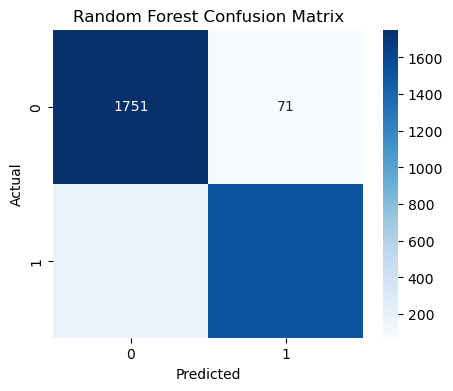


📌 SVM Performance:
Accuracy: 0.9048
AUC-ROC: 0.9555
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1822
           1       0.94      0.85      0.90      1697

    accuracy                           0.90      3519
   macro avg       0.91      0.90      0.90      3519
weighted avg       0.91      0.90      0.90      3519



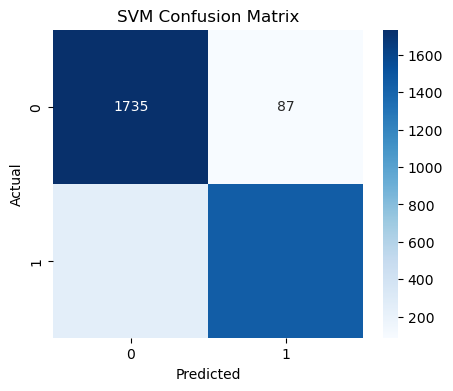


📌 AdaBoost Performance:
Accuracy: 0.9253
AUC-ROC: 0.9726
              precision    recall  f1-score   support

           0       0.90      0.96      0.93      1822
           1       0.96      0.88      0.92      1697

    accuracy                           0.93      3519
   macro avg       0.93      0.92      0.92      3519
weighted avg       0.93      0.93      0.93      3519



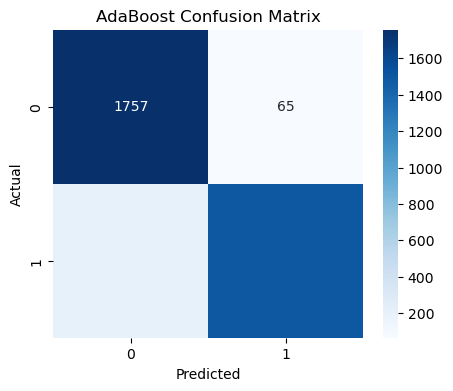


📌 Gradient Boosting Performance:
Accuracy: 0.9273
AUC-ROC: 0.9742
              precision    recall  f1-score   support

           0       0.90      0.97      0.93      1822
           1       0.96      0.89      0.92      1697

    accuracy                           0.93      3519
   macro avg       0.93      0.93      0.93      3519
weighted avg       0.93      0.93      0.93      3519



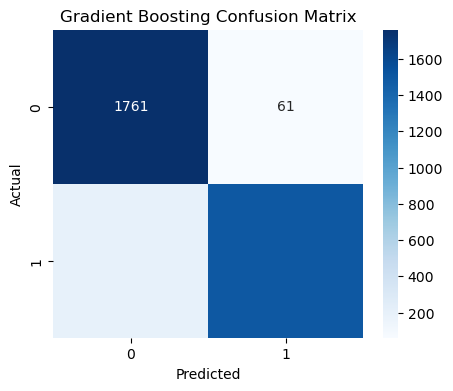

110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

📌 DNN Performance:
Accuracy: 0.8772
AUC-ROC: 0.8978
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1822
           1       0.92      0.82      0.87      1697

    accuracy                           0.88      3519
   macro avg       0.88      0.88      0.88      3519
weighted avg       0.88      0.88      0.88      3519



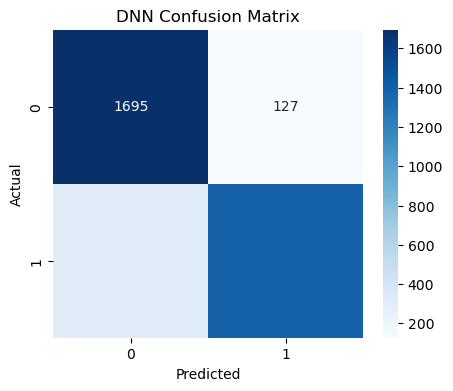

c:\Users\krupa\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


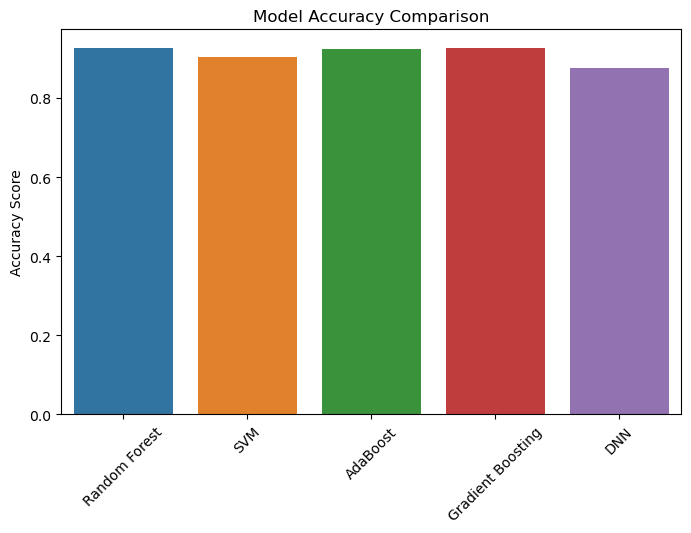

c:\Users\krupa\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


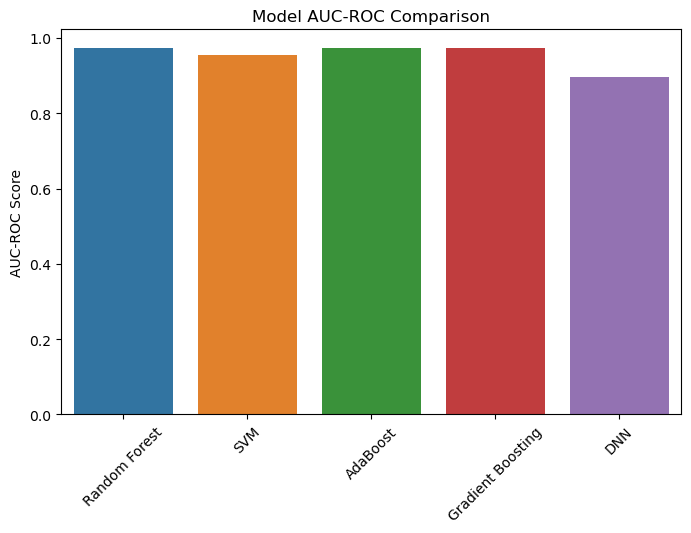

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Define mapping for string predictions to numeric labels
label_mapping = {'benign': 0, 'malicious': 1}

# Store model names and predictions
models = {
    "Random Forest": final_rf,
    "SVM": final_svm,
    "AdaBoost": final_ada,
    "Gradient Boosting": final_gb,
    "DNN": final_dnn
}

# Initialize lists for comparison
accuracy_scores = []
auc_scores = []

# Iterate over models and evaluate
for name, model in models.items():
    if name == "DNN":  # Special handling for deep learning model
        y_proba = model.predict(X_test)
        y_pred = y_proba.argmax(axis=1)
        auc = roc_auc_score(y_test, y_proba[:, 1])
    else:
        y_pred = model.predict(X_test)
        # Convert string predictions to numeric if needed
        y_pred = [label_mapping[label] if isinstance(label, str) else label for label in y_pred]
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    
    acc = accuracy_score(y_test, y_pred)
    accuracy_scores.append(acc)
    auc_scores.append(auc)
    
    print(f"\n📌 {name} Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Plot Accuracy & AUC-ROC Score
plt.figure(figsize=(8, 5))
sns.barplot(x=list(models.keys()), y=accuracy_scores)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy Score")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x=list(models.keys()), y=auc_scores)
plt.title("Model AUC-ROC Comparison")
plt.ylabel("AUC-ROC Score")
plt.xticks(rotation=45)
plt.show()


**Find and Save Best Model**

In [45]:
# Store model names and their scores
model_scores = {
    "Random Forest": roc_auc_score(y_test, final_rf.predict_proba(X_test)[:, 1]),
    "SVM": roc_auc_score(y_test, final_svm.predict_proba(X_test)[:, 1]),
    "AdaBoost": roc_auc_score(y_test, final_ada.predict_proba(X_test)[:, 1]),
    "Gradient Boosting": roc_auc_score(y_test, final_gb.predict_proba(X_test)[:, 1]),
    "DNN": roc_auc_score(y_test, final_dnn.predict(X_test)[:, 1])  # Special handling for DNN
}

# Select the best model
best_model_name = max(model_scores, key=model_scores.get)
print(f"\n🏆 Best Model Selected: {best_model_name} with AUC-ROC: {model_scores[best_model_name]:.4f}")

# Save the best model
import joblib

if best_model_name == "DNN":
    final_dnn.save("best_model.h5")  # Save Keras model
    print("✅ Best Model Saved as 'best_model.h5'")
else:
    best_model = {
        "Random Forest": final_rf,
        "SVM": final_svm,
        "AdaBoost": final_ada,
        "Gradient Boosting": final_gb
    }[best_model_name]

    joblib.dump(best_model, "best_model.pkl")  # Save Sklearn model
    print("✅ Best Model Saved as 'best_model.pkl'")


110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

🏆 Best Model Selected: Gradient Boosting with AUC-ROC: 0.9742
✅ Best Model Saved as 'best_model.pkl'


In [56]:
import pandas as pd
import joblib
from sklearn.preprocessing import StandardScaler

# Load training dataset
df_train = pd.read_csv(r"D:\Final_Batch_1\file_dataset.csv")

# Print available columns
print("✅ Available columns in dataset:", df_train.columns.tolist())

# Define features used for training (should match inference)
FEATURE_COLUMNS = [
    "pdf_version", "num_pages", "has_javascript",
    "file_size_kb", "has_embedded_files", "has_openaction",
    "has_launch", "header_length", "is_encrypted"
]


# Ensure all required features exist
missing_features = [col for col in FEATURE_COLUMNS if col not in df_train.columns]
if missing_features:
    raise ValueError(f"❌ Missing columns in dataset: {missing_features}")

# Extract and clean features
X_train = df_train[FEATURE_COLUMNS].copy()
X_train.replace(["-1.-1", "-1"], pd.NA, inplace=True)
X_train = X_train.apply(pd.to_numeric, errors="coerce")
X_train.fillna(X_train.mean(), inplace=True)

# Fit StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

# Save the scaler
joblib.dump(scaler, "scaler.pkl")
print("✅ Scaler saved as scaler.pkl with features:", FEATURE_COLUMNS)


✅ Available columns in dataset: ['filename', 'label', 'header_length', 'file_size_kb', 'file_type', 'text_preview', 'num_pages', 'is_encrypted', 'pdf_version', 'has_javascript', 'has_embedded_files', 'has_openaction', 'has_launch']
✅ Scaler saved as scaler.pkl with features: ['pdf_version', 'num_pages', 'has_javascript', 'file_size_kb', 'has_embedded_files', 'has_openaction', 'has_launch', 'header_length', 'is_encrypted']


In [55]:
import pandas as pd

df = pd.read_csv("D:/Final_Batch_1/file_dataset.csv")
print(df.columns.tolist())


['filename', 'label', 'header_length', 'file_size_kb', 'file_type', 'text_preview', 'num_pages', 'is_encrypted', 'pdf_version', 'has_javascript', 'has_embedded_files', 'has_openaction', 'has_launch']


In [57]:
print("Features used in training:", FEATURE_COLUMNS)

Features used in training: ['pdf_version', 'num_pages', 'has_javascript', 'file_size_kb', 'has_embedded_files', 'has_openaction', 'has_launch', 'header_length', 'is_encrypted']


In [58]:
import joblib

model = joblib.load("best_model.pkl")
print("✅ Features expected by model:", model.feature_names_in_)


✅ Features expected by model: ['header_length' 'file_size_kb' 'num_pages' 'is_encrypted'
 'has_javascript' 'has_embedded_files' 'has_openaction' 'has_launch']
